<a href="https://colab.research.google.com/github/hsantos1985/ds_projects/blob/main/CASE_PARA_REVISAO_CLASSIFICACAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1-INTALAÇÃO DAS BIBLIOTECAS

In [ ]:
!pip install feature-engine lightgbm xgboost catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
#BIBLIOTECAS PARA SEPARAÇÃO DOS DADOS E PANDAS
from sklearn.model_selection import train_test_split
import pandas as pd
import os

#2-CARREGANDO OS DADOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#ABT JÁ FOI CRIADA
df_abt = pd.read_csv('/content/drive/My Drive/datasets/propensao_revenda_abt_revisao_case.csv')

In [ ]:
df_abt.head(10)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_2m
0,2018-01-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,74,1
1,2018-01-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2,0
2,2018-01-01,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2,0
3,2018-01-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,16,1
4,2018-01-01,004c9cd9d87a3c30c522c48c4fc07416,SP,130,141,75,16228.88,8,0
5,2018-01-01,00ab3eff1b5192e5f1a63bcecfee11c8,SP,1,1,1,98.00,288,1
6,2018-01-01,00ee68308b45bc5e2660cd833c3f81cc,SP,40,49,12,4641.00,2,0
7,2018-01-01,010543a62bd80aa422851e79a3bc7540,SP,2,2,1,1416.00,151,1
8,2018-01-01,013900e863eace745d3ec7614cab5b1a,PR,10,13,10,768.70,9,0
9,2018-01-01,014c0679dd340a0e338872e7ec85666a,MG,7,7,4,2572.00,17,0


In [ ]:
#verificando as safras
df_abt['data_ref_safra'].nunique()


6

In [ ]:
#verificando as safras
df_abt['data_ref_safra'].unique()

array(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01'], dtype=object)

#3-SEPARAÇÃO DAS BASES EM TREINO E OOT

In [ ]:
df_abt_train=(
df_abt
 .query('data_ref_safra<"2018-05-01"')
 .copy()
 )

In [ ]:
df_abt_oot=(
  df_abt
 .query('data_ref_safra>="2018-05-01"')
 .copy()
)

#4-SEPARAÇÃO DAS VARIÁVEIS

In [ ]:
key_vars=['data_ref_safra', 'seller_id']
num_vars=['tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia']
cat_vars=['uf']

target='nao_revendeu_next_2m'
features=num_vars+cat_vars

In [ ]:
y_train=df_abt_train[target]

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
X_train=df_abt_train[cat_vars]

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
X_train=df_abt_train[features]
y_train=df_abt_train[target]

X_oot=df_abt_oot[features]
y_oot=df_abt_oot[target]

#5-AUTOMATIZAÇÃO DA TRANSFORMAÇÃO DOS DADOS

In [ ]:
#BIBLIOTECAS PARA AS ETAPAS DE TRANSFORMAÇÃO DAS VARIÁVEIS
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper

In [ ]:
#ETAPAS DE TRANSFORMAÇÃO
steps_comuns=[('numeric_imputer',MeanMedianImputer(variables=num_vars, imputation_method='median')),
              ('categoric_imputer',CategoricalImputer(variables=cat_vars)),
              ('one_hot_enconder',OneHotEncoder(variables=cat_vars))
              ]
steps_linear=[('numeric_scaler',SklearnTransformerWrapper(variables=num_vars,transformer=StandardScaler()))]

random_state=42

In [ ]:
#BIBLIOTECAS PARA OS ALGORITMOS
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
#ETAPAS DOS ALGORITMOS
algoritmos = {
    'linear': [
        ('logistic_regression', LogisticRegression(random_state=random_state))
    ],
    'tree': [
        ('dt', DecisionTreeClassifier(random_state=random_state)),
        ('random_forest', RandomForestClassifier(random_state=random_state)),
        ('xgb', XGBClassifier(random_state=random_state)),
        ('lgbm', LGBMClassifier(random_state=random_state, verbose=0)),
        ('catboost', CatBoostClassifier(random_state=random_state, verbose=0))
    ]
}

#6-TREINANDO VARIOS MODELOS

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [ ]:


df = pd.DataFrame(columns=['acc', 'precision', 'recall', 'f1', 'roc_auc'])

for type_algorithms, algorithms in algoritmos.items():
    if type_algorithms == 'linear':
        steps = steps_comuns + steps_linear
    elif type_algorithms == 'tree':
        steps = steps_comuns

    for alg in algorithms:
        nome = alg[0]
        print(f'Treinando o algoritmo {nome}', end=' ... ')
        model_pipe = Pipeline(steps=steps + [alg])
        result_cv = cross_validate(estimator=model_pipe, X=X_train, y=y_train, cv=5, scoring=['accuracy','precision', 'recall', 'f1', 'roc_auc'])
        s = pd.DataFrame(result_cv).mean()
        df.loc[nome] = [
            s['test_accuracy'],
            s['test_precision'],
            s['test_recall'],
            s['test_f1'],
            s['test_roc_auc']
        ]
        print('OK!')

Treinando o algoritmo logistic_regression ... OK!
Treinando o algoritmo dt ... OK!
Treinando o algoritmo random_forest ... OK!
Treinando o algoritmo xgb ... OK!
Treinando o algoritmo lgbm ... OK!
Treinando o algoritmo catboost ... OK!


In [ ]:
df.sort_values('roc_auc',ascending=False)

,acc,precision,recall,f1,roc_auc
random_forest,0.820657,0.816208,0.789630,0.802614,0.906238
catboost,0.828865,0.825329,0.798519,0.811605,0.905841
lgbm,0.820657,0.814810,0.792000,0.803145,0.901305
xgb,0.818057,0.809407,0.792889,0.800950,0.901096
logistic_regression,0.806430,0.849994,0.705481,0.770871,0.894615
dt,0.747196,0.722139,0.735704,0.728752,0.746378


In [ ]:
#escolhendo o XGB com menor roc_auc que o rf, mas o recall é maior
melhor_modelo=Pipeline(steps=steps_comuns+[('xgb',XGBClassifier(random_state=random_state))])
melhor_modelo

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_enconder', OneHotEncoder(variables=['uf'])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
melhor_modelo.fit(X_train, y_train)

Pipeline(steps=[('numeric_imputer',
                 MeanMedianImputer(variables=['tot_orders_12m', 'tot_items_12m',
                                              'tot_items_dist_12m',
                                              'receita_12m', 'recencia'])),
                ('categoric_imputer', CategoricalImputer(variables=['uf'])),
                ('one_hot_enconder', OneHotEncoder(variables=['uf'])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

#7-MÉTRICAS DO MELHOR MODELO

In [ ]:
#metricas
from sklearn.metrics import roc_auc_score, recall_score

y_pred_train = melhor_modelo.predict(X_train)
y_pred_oot = melhor_modelo.predict(X_oot)

y_proba_train = melhor_modelo.predict_proba(X_train)[:,1]
y_proba_oot = melhor_modelo.predict_proba(X_oot)[:,1]

print('ROC AUC Train: ', roc_auc_score(y_train, y_proba_train))
print('ROC AUC OOT: ', roc_auc_score(y_oot, y_proba_oot))
print()
print('Recall Train: ', recall_score(y_train, y_pred_train))
print('Recall OOT: ', recall_score(y_oot, y_pred_oot))

ROC AUC Train:  0.9787709162784132
ROC AUC OOT:  0.891133112624149

Recall Train:  0.8974814814814814
Recall OOT:  0.7729064039408867


#8-HIPERPARÂMETROS DO MELHOR MODELO

In [ ]:
#importando as bibliotecas
import time
t3 = time.time()
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#pipeline
pipeline=Pipeline(steps=steps_comuns+[('xgboost',XGBClassifier())])

In [ ]:
parametros = {
    'xgboost__learning_rate': [0.1, 0.015],
    'xgboost__n_estimators': [100, 500],
    'xgboost__max_depth': [3, 17],
    'xgboost__colsample_bytree': [0.2, 0.7],
    'xgboost__subsample': [0.1, 0.6],
    'xgboost__class_weight': [None]
}

melhor_modelo_otimizado = GridSearchCV(pipeline, parametros, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
melhor_modelo_otimizado.fit(X_train, y_train)



Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('numeric_imputer',
                                        MeanMedianImputer(variables=['tot_orders_12m',
                                                                     'tot_items_12m',
                                                                     'tot_items_dist_12m',
                                                                     'receita_12m',
                                                                     'recencia'])),
                                       ('categoric_imputer',
                                        CategoricalImputer(variables=['uf'])),
                                       ('one_hot_enconder',
                                        OneHotEncoder(variables=['uf'])),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__class_weight': [None],
                         'xgboost__colsample_bytree': [0.2, 0.7],
                         'xgboost__learning_rate': [0.1, 0.015],
                         'xgboost__max_depth': [3, 17],
                         'xgboost__n_estimators': [100, 500],
                         'xgboost__subsample': [0.1, 0.6]},
             scoring='roc_auc', verbose=1)

In [ ]:
print()
print('='*100)
print(melhor_modelo_otimizado.best_params_)
print('\nDemorou {} segundos para GridSearch para XGBoost.'.format(time.time() - t3))
print('='*100)
print()


{'xgboost__class_weight': None, 'xgboost__colsample_bytree': 0.7, 'xgboost__learning_rate': 0.015, 'xgboost__max_depth': 17, 'xgboost__n_estimators': 500, 'xgboost__subsample': 0.6}

Demorou 171.08677649497986 segundos para GridSearch para XGBoost.



In [ ]:
#metricas
y_pred_train = melhor_modelo_otimizado.predict(X_train)
y_pred_oot = melhor_modelo_otimizado.predict(X_oot)

y_proba_train = melhor_modelo_otimizado.predict_proba(X_train)[:,1]
y_proba_oot = melhor_modelo_otimizado.predict_proba(X_oot)[:,1]

print('ROC AUC Train: ', roc_auc_score(y_train, y_proba_train))
print('ROC AUC OOT: ', roc_auc_score(y_oot, y_proba_oot))
print()
print('Recall Train: ', recall_score(y_train, y_pred_train))
print('Recall OOT: ', recall_score(y_oot, y_pred_oot))

ROC AUC Train:  0.9923004000188244
ROC AUC OOT:  0.8912449031902314

Recall Train:  0.9442962962962963
Recall OOT:  0.7812807881773399


#9-GANHO FINANCEIRO

In [ ]:
df_abt_oot.head(10)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_2m
7310,2018-05-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,194,1
7311,2018-05-01,001cca7ae9ae17fb1caed9dfb1094831,ES,164,189,10,19731.83,2,0
7312,2018-05-01,002100f778ceb8431b7a1020ff7ab48f,SP,50,54,24,1216.60,18,1
7313,2018-05-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,136,1
7314,2018-05-01,004c9cd9d87a3c30c522c48c4fc07416,SP,121,126,62,14122.09,13,0
7315,2018-05-01,00720abe85ba0859807595bbf045a33b,SP,7,13,6,439.70,6,0
7316,2018-05-01,00d8b143d12632bad99c0ad66ad52825,MG,1,1,1,86.00,40,1
7317,2018-05-01,00ee68308b45bc5e2660cd833c3f81cc,SP,129,164,21,19650.00,5,0
7318,2018-05-01,00fc707aaaad2d31347cf883cd2dfe10,PR,100,132,17,12298.50,3,0
7319,2018-05-01,010543a62bd80aa422851e79a3bc7540,SP,2,2,1,1416.00,271,1


In [ ]:
df_abt_oot.columns

Index(['data_ref_safra', 'seller_id', 'uf', 'tot_orders_12m', 'tot_items_12m',
       'tot_items_dist_12m', 'receita_12m', 'recencia',
       'nao_revendeu_next_2m'],
      dtype='object')

In [ ]:
melhor_modelo_otimizado.predict(X_oot)

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
melhor_modelo_otimizado.predict_proba(X_oot)[:,1]

array([0.9477763 , 0.01093554, 0.03203056, ..., 0.27713913, 0.11647231,
       0.00757609], dtype=float32)

In [ ]:
#TESTANDO OS CORTES DE 0,4 E 0,5 %
import numpy as np

df_abt_oot['predicted_class_thr_05'] = melhor_modelo_otimizado.predict(X_oot)
df_abt_oot['proba_class_1'] = melhor_modelo.predict_proba(X_oot)[:, 1]
df_abt_oot['predicted_class_thr_04'] = np.where(df_abt_oot['proba_class_1'] >= 0.4, 1, 0)
df_abt_oot.head(10)



,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_2m,predicted_class_thr_05,proba_class_1,predicted_class_thr_04
7310,2018-05-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,194,1,1,0.958986,1
7311,2018-05-01,001cca7ae9ae17fb1caed9dfb1094831,ES,164,189,10,19731.83,2,0,0,0.011902,0
7312,2018-05-01,002100f778ceb8431b7a1020ff7ab48f,SP,50,54,24,1216.60,18,1,0,0.059893,0


In [ ]:
df_abt_oot.head(10)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_2m,predicted_class_thr_05,proba_class_1,predicted_class_thr_04
7310,2018-05-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,194,1,1,0.958986,1
7311,2018-05-01,001cca7ae9ae17fb1caed9dfb1094831,ES,164,189,10,19731.83,2,0,0,0.011902,0
7312,2018-05-01,002100f778ceb8431b7a1020ff7ab48f,SP,50,54,24,1216.60,18,1,0,0.059893,0
7313,2018-05-01,003554e2dce176b5555353e4f3555ac8,GO,1,1,1,120.00,136,1,1,0.945077,1
7314,2018-05-01,004c9cd9d87a3c30c522c48c4fc07416,SP,121,126,62,14122.09,13,0,0,0.005770,0
7315,2018-05-01,00720abe85ba0859807595bbf045a33b,SP,7,13,6,439.70,6,0,0,0.192509,0
7316,2018-05-01,00d8b143d12632bad99c0ad66ad52825,MG,1,1,1,86.00,40,1,1,0.822335,1
7317,2018-05-01,00ee68308b45bc5e2660cd833c3f81cc,SP,129,164,21,19650.00,5,0,0,0.024117,0
7318,2018-05-01,00fc707aaaad2d31347cf883cd2dfe10,PR,100,132,17,12298.50,3,0,0,0.042536,0
7319,2018-05-01,010543a62bd80aa422851e79a3bc7540,SP,2,2,1,1416.00,271,1,1,0.990971,1


In [ ]:
y_pred_oot = df_abt_oot['predicted_class_thr_04']
y_proba_oot = df_abt_oot['proba_class_1']

print('Recall Train: ', recall_score(y_train, y_pred_train))
print('Recall OOT: ', recall_score(y_oot, y_pred_oot))

Recall Train:  0.9442962962962963
Recall OOT:  0.8142857142857143


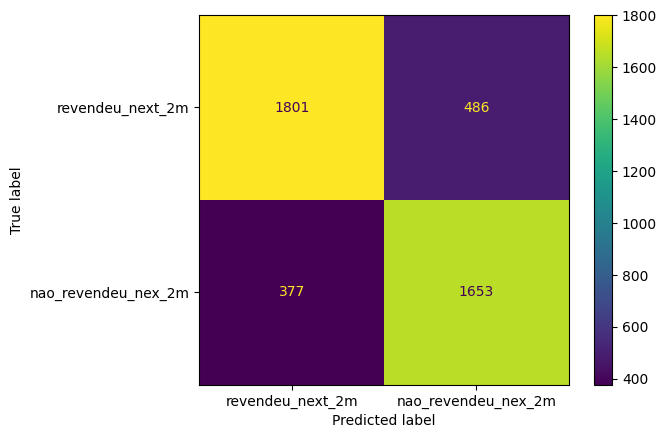

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_oot,
    df_abt_oot['predicted_class_thr_04'],
    values_format='d',
    display_labels=['revendeu_next_2m', 'nao_revendeu_nex_2m'],
)


In [ ]:
#calculo das metricas com treshold de 0.4%
#acuracia = (1801+1653)/(1801+1653+377+486)
#0.8000926569376882
(1801+1653)/(1801+1653+377+486)


0.8000926569376882

In [ ]:
#Recall, revoção, sensibilidade
(1801)/(1801+486)
#0.7874945343244425

0.7874945343244425

In [ ]:
#especificidade
(1653)/(1653+377)
#0.8142857142857143

0.8142857142857143

In [ ]:
#precisao
(1801)/(1801+377)
#0.8269054178145088


0.8269054178145088

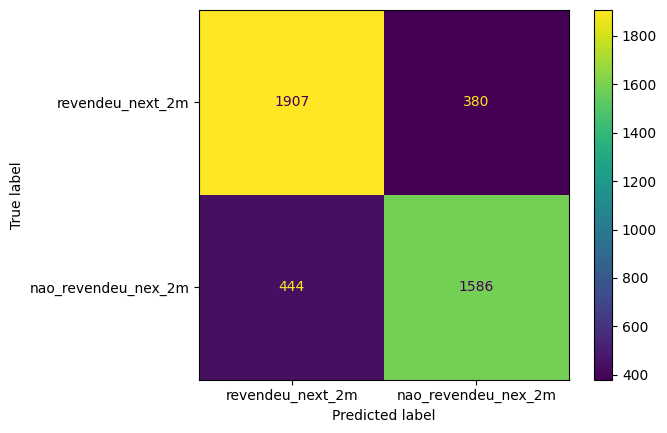

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_oot,
    df_abt_oot['predicted_class_thr_05'],
    values_format='d',
    display_labels=['revendeu_next_2m', 'nao_revendeu_nex_2m'],
)


In [ ]:
#calculo das metricas com treshold de 0.5%
#acuracia = (1907+1586)/(1907+1586+444+380)
(1907+1586)/(1907+1586+444+380)
#0.8091267083622886

0.8091267083622886

In [ ]:
#Recall, revoção, sensibilidade
(1907)/(1907+380)
#0.8338434630520333

0.8338434630520333

In [ ]:
#especificidade
(1586)/(1586+444)
#0.7812807881773399

0.7812807881773399

In [ ]:
#precisao
(1907)/(1907+444)
#0.811144193960017

0.811144193960017

In [ ]:
comissao_2m = (
    df_abt_train
    .query('nao_revendeu_next_2m == 1')
    .assign(comissao_2m = lambda df: df['receita_12m'] * 0.08)
    .filter(['comissao_2m'])
    .mean()
).iloc[0].round()

comissao_2m

102.0

In [ ]:
from sklearn.metrics import confusion_matrix
true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_oot, y_pred_oot).ravel()

In [ ]:
false_class = true_negative + false_positive
true_class = false_negative + true_positive

comissao = comissao_2m
valor_cupom = 50

total_comissao_perdida = (true_class * comissao )
economia_bruta = (total_comissao_perdida) - (false_negative * comissao)
custo_atuacao_modelo = (true_positive + false_positive) * valor_cupom
economia_efetiva = economia_bruta - custo_atuacao_modelo
economia_efetiva

61656.0